# Home Energy Management with Dynamic Tariffs and Peak Power Charges

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm

# Customize plot settings
from latexify import *
from utils import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
latexify(fig_width=5)

## Problem data

In [2]:
load_data = pd.read_csv('data/loads.csv', parse_dates=[0], index_col=0)["Load (kW)"]
load_min, load_max = load_data.min(), load_data.max()
tou_price_data = pd.read_csv('data/tou_prices.csv', parse_dates=[0], index_col=0)["TOU Price (NOK/kWh)"]
da_price_data = pd.read_csv('data/da_prices.csv', parse_dates=[0], index_col=0)["DA Price (NOK/kWh)"]
da_price_min, da_price_max = da_price_data.min(), da_price_data.max()

# Load forecasting
load_baseline = pd.read_csv('data/load_baseline.csv', parse_dates=[0], index_col=0)["Baseline load (kW)"]
load_AR_params = pd.read_pickle("data/load_AR_params.pickle")

# Day-ahead price forecasting
da_price_baseline = pd.read_csv('data/da_price_baseline.csv', parse_dates=[0], index_col=0)["Baseline day-ahead price (NOK/kWh)"]
da_price_AR_params = pd.read_pickle("data/da_price_AR_params.pickle")

# Define simulation window: one year (2022) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00", tz=None)

sim_start_time = load_data.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_datetime_index = load_data.index[sim_start_time:sim_end_time]

# Load and price values for 2022
load = load_data.iloc[sim_start_time:sim_end_time].values
tou_prices = tou_price_data.iloc[sim_start_time:sim_end_time].values
da_prices = da_price_data.iloc[sim_start_time:sim_end_time].values

## Baseline analysis: no storage

Total cost: 25,051.67 NOK
	Time-of-use energy charges: 8,684.94 NOK (34.67% of total cost)
	Day-ahead energy charges: 13,342.74 NOK (53.26% of total cost)
	Peak power charges: 3,024.00 NOK (12.07% of total cost)



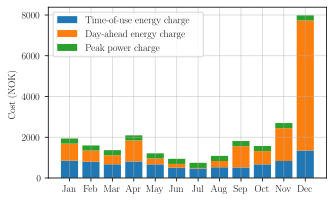

In [3]:
monthly_tou_costs, monthly_da_costs, monthly_peak_costs, tou_cost, da_cost, peak_cost = compute_costs(tou_prices, da_prices, load, sim_datetime_index)
cost_no_storage = tou_cost + da_cost + peak_cost
print_cost_summary(tou_cost, da_cost, peak_cost)

# Plot monthly cost breakdown
fig, ax = plt.subplots()
bar_width = 0.8
months = np.arange(1, 13)
plt.bar(months, monthly_tou_costs, bar_width, color="tab:blue", label='Time-of-use energy charge')
plt.bar(months, monthly_da_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Day-ahead energy charge')
plt.bar(months, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_da_costs)], color="tab:green", label='Peak power charge')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend()
plt.savefig("figures/cost_no_storage.pdf")

## Prescient problem (perfect foresight)

In [4]:
# Solve prescient problem
p, q, c, d, cost, problem_status = optimize(load=load, tou_prices=tou_prices, da_prices=da_prices, T=T, datetime_index=sim_datetime_index, N=3, verbose=False, solver=cp.GUROBI)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-13


### Cost

Total cost: 21,203.53 NOK
	Time-of-use energy charges: 8,373.63 NOK (39.49% of total cost)
	Day-ahead energy charges: 11,024.91 NOK (52.00% of total cost)
	Peak power charges: 1,805.00 NOK (8.51% of total cost)



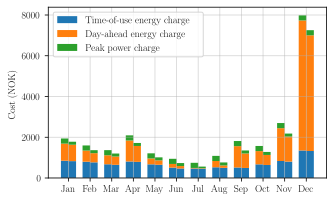

In [5]:
# Plot monthly costs with and woithout storage over the whole year
monthly_tou_costs_prescient, monthly_da_costs_prescient, monthly_peak_costs_prescient, tou_cost_prescient, da_cost_prescient, peak_cost_prescient = compute_costs(tou_prices, da_prices, p, sim_datetime_index, round=True)
cost_prescient = tou_cost_prescient + da_cost_prescient + peak_cost_prescient
print_cost_summary(tou_cost_prescient, da_cost_prescient, peak_cost_prescient)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, monthly_tou_costs, bar_width, color="tab:blue", label='Time-of-use energy charge')
plt.bar(months - bar_offset, monthly_da_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Day-ahead energy charge')
plt.bar(months - bar_offset, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_da_costs)], color="tab:green", label='Peak power charge')
plt.bar(months + bar_offset, monthly_tou_costs_prescient, bar_width, color="tab:blue")
plt.bar(months + bar_offset, monthly_da_costs_prescient, bar_width, bottom=monthly_tou_costs_prescient, color="tab:orange")
plt.bar(months + bar_offset, monthly_peak_costs_prescient, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_prescient, monthly_da_costs_prescient)], color="tab:green")
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend(loc="upper left")
plt.savefig("figures/cost_prescient.pdf")

### Power flows over 2022

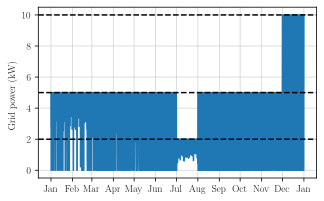

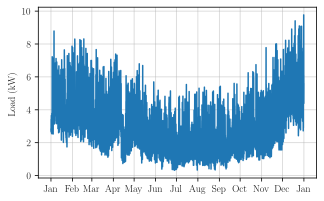

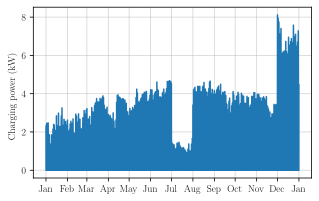

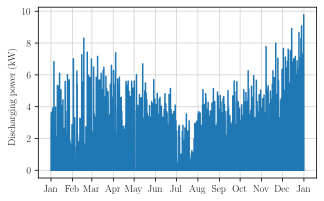

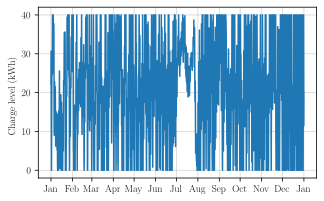

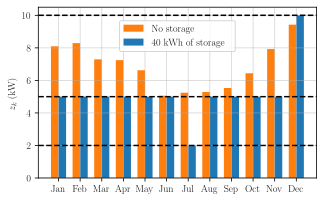

In [6]:
# Grid power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, p, color="tab:blue")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed') 
ax.axhline(10, color='black', linestyle='dashed')
plt.ylabel("Grid power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/p_prescient.pdf")

# Load
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:blue")
plt.ylabel("Load (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/l_prescient.pdf")

# Charging storage power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, c, color="tab:blue")
plt.ylabel("Charging power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/c_prescient.pdf")

# Discharging storage power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, d, color="tab:blue")
plt.ylabel("Discharging power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/d_prescient.pdf")

# Charge level
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q[1:], color="tab:blue")
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/q_prescient.pdf")

# Comparison of z values (monthly average of N largest maximum daily powers)
z_load = get_z_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient = get_z_values(power=p, datetime_index=sim_datetime_index, N=3)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, z_load, bar_width, color="tab:orange", label="No storage")
plt.bar(months + bar_offset, z_prescient, bar_width, color="tab:blue", label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed') 
ax.axhline(10, color='black', linestyle='dashed')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('$z_k$ (kW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.savefig("figures/z_prescient.pdf")

### Power flows over one week in July 2022

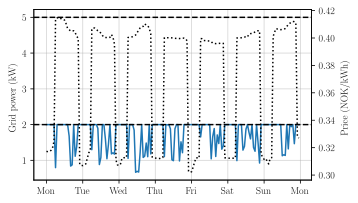

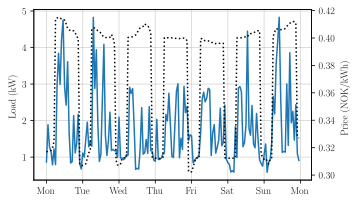

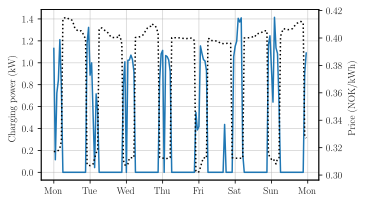

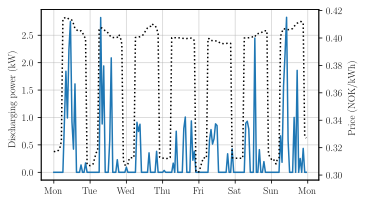

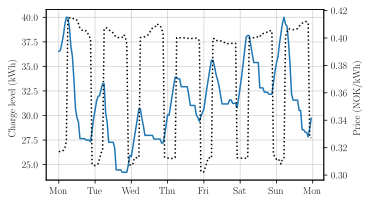

In [7]:
p_series = pd.Series(p, index=sim_datetime_index)
l_series = pd.Series(load, index=sim_datetime_index)
c_series = pd.Series(c, index=sim_datetime_index)
d_series = pd.Series(d, index=sim_datetime_index)
q_series = pd.Series(q[1:], index=sim_datetime_index)
price_series = pd.Series(da_prices + tou_prices, index=sim_datetime_index)


# Grid power
fig, ax = plt.subplots()
ax.plot(p_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed')
plt.ylabel("Grid power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/p_prescient_week.pdf")


# Load
fig, ax = plt.subplots()
ax.plot(l_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Load (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/l_prescient_week.pdf")

# Charging storage power
fig, ax = plt.subplots()
ax.plot(c_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Charging power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/c_prescient_week.pdf")

# Discharging storage power
fig, ax = plt.subplots()
ax.plot(d_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Discharging power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/d_prescient_week.pdf")

# Charge level
fig, ax = plt.subplots()
ax.plot(q_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Charge level (kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/q_prescient_week.pdf")


### Cost versus storage capacity

100%|██████████| 50/50 [04:38<00:00,  5.57s/it]


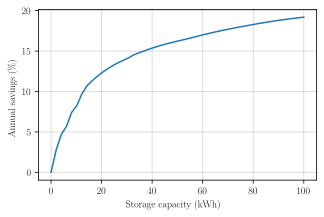

In [8]:
storage_capacities = np.linspace(0, 100)
costs = np.zeros_like(storage_capacities)
    
for i, Q in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities)):
    p, q, _, _, cost, _ = optimize(load=load, tou_prices=tou_prices, da_prices=da_prices, T=T, datetime_index=sim_datetime_index, Q=Q, C=Q/2, D=Q/2, q_init=Q/2, q_final=Q/2, verbose=False, solver=cp.GUROBI)
    costs[i] = cost
    
savings_percetage = (costs[0] - costs)/costs[0] * 100

plt.figure()
plt.plot(storage_capacities, savings_percetage, color="tab:blue", linestyle="solid")
plt.xlabel("Storage capacity (kWh)")
plt.ylabel("Annual savings (\%)")

plt.savefig("figures/cost_vs_storage_capacity.pdf")

## Model predictive control

In [9]:
# Constants
eff_s, eff_c, eff_d = 0.99998, 0.95, 0.95
q_init = 20
M, L = 24, 23
H = 24*30

# Simulation window
T = 24*365

# Empty arrays to store results
p_mpc = np.zeros(T)
c_mpc = np.zeros(T)
d_mpc = np.zeros(T)
q_mpc = np.zeros(T+1)
p_prev = []

# Initial conditions
q_mpc[0] = q_init
prev_datetime = sim_datetime_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Reset p_prev if new month
    if prev_datetime.month != sim_datetime_index[t].month:
        p_prev = []
    
    # Make forecasts
    load_forecast = make_load_forecast(load_data, load_baseline, load_AR_params, sim_start_time, t, H, M, L, load_min, load_max)
    da_price_forecast = make_da_price_forecast(da_price_data, da_price_baseline, da_price_AR_params, sim_start_time, t, H, M, L, da_price_min, da_price_max)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetime index for the planning horizon and for the hours in the current month so far
    datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    datetime_index_prev = sim_datetime_index[(sim_datetime_index.month == sim_datetime_index[t].month) & (sim_datetime_index < sim_datetime_index[t])]
    
    # # Optimize (plan sequence of actions) over a horizon
    p, q, c, d, cost, problem_status = optimize(load=load_forecast, tou_prices=tou_price_forecast, da_prices=da_price_forecast, T=H, datetime_index=datetime_index_horizon, q_init=q_mpc[t], p_prev=p_prev, datetime_index_prev=datetime_index_prev, N=1, verbose=False, solver=cp.GUROBI)

    # Execute first action in the plan
    p_mpc[t] = p[0]
    c_mpc[t] = c[0]
    d_mpc[t] = d[0]
    q_mpc[t+1] =  eff_s * q_mpc[t] + eff_c * c[0] - (1/eff_d) * d[0]
    prev_datetime = sim_datetime_index[t]
    p_prev.append(p[0])
        

100%|██████████| 8760/8760 [25:16<00:00,  5.78it/s]


### Cost

Total cost: 21,563.47 NOK
	Time-of-use energy charges: 8,235.50 NOK (38.19% of total cost)
	Day-ahead energy charges: 11,038.97 NOK (51.19% of total cost)
	Peak power charges: 2,289.00 NOK (10.62% of total cost)



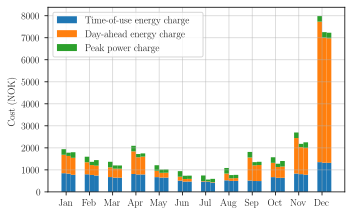

In [10]:
# Plot monthly costs with and woithout storage over the whole year
monthly_tou_costs_mpc, monthly_da_costs_mpc, monthly_peak_costs_mpc, tou_cost_mpc, da_cost_mpc, peak_cost_mpc = compute_costs(tou_prices, da_prices, p_mpc, sim_datetime_index, round=True)
cost_mpc = tou_cost_mpc + da_cost_mpc + peak_cost_mpc
print_cost_summary(tou_cost_mpc, da_cost_mpc, peak_cost_mpc)

fig, ax = plt.subplots()
bar_width = 0.2
bar_offset = bar_width / 2

plt.bar(months - bar_offset, monthly_tou_costs, bar_width, color="tab:blue", label='Time-of-use energy charge')
plt.bar(months - bar_offset, monthly_da_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Day-ahead energy charge')
plt.bar(months - bar_offset, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_da_costs)], color="tab:green", label='Peak power charge')

plt.bar(months + bar_offset, monthly_tou_costs_prescient, bar_width, color="tab:blue")
plt.bar(months + bar_offset, monthly_da_costs_prescient, bar_width, bottom=monthly_tou_costs_prescient, color="tab:orange")
plt.bar(months + bar_offset, monthly_peak_costs_prescient, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_prescient, monthly_da_costs_prescient)], color="tab:green")

plt.bar(months + 3*bar_offset, monthly_tou_costs_mpc, bar_width, color="tab:blue")
plt.bar(months + 3*bar_offset, monthly_da_costs_mpc, bar_width, bottom=monthly_tou_costs_mpc, color="tab:orange")
plt.bar(months + 3*bar_offset, monthly_peak_costs_mpc, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_mpc, monthly_da_costs_mpc)], color="tab:green")

plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend()
plt.tight_layout()
plt.savefig("figures/cost_mpc.pdf")

### Power flows over 2022

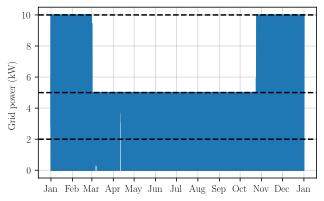

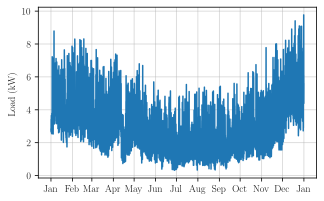

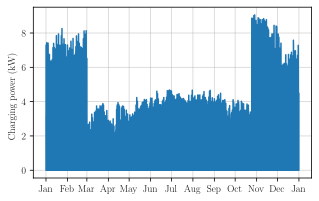

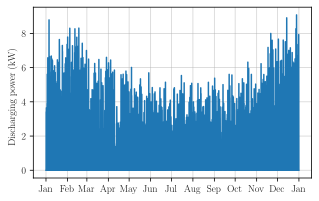

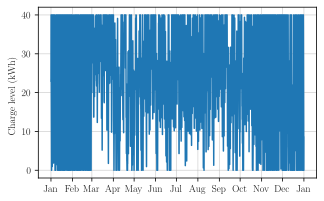

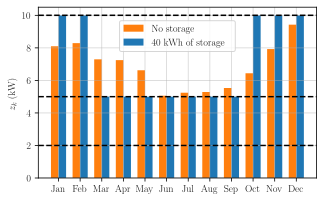

In [11]:
# Grid power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, p_mpc, color="tab:blue")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed') 
ax.axhline(10, color='black', linestyle='dashed')
plt.ylabel("Grid power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/p_mpc.pdf")

# Load
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:blue")
plt.ylabel("Load (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/l_mpc.pdf")

# Charging storage power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, c_mpc, color="tab:blue")
plt.ylabel("Charging power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/c_mpc.pdf")

# Discharging storage power
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, d_mpc, color="tab:blue")
plt.ylabel("Discharging power (kW)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/d_mpc.pdf")

# Charge level
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q_mpc[1:], color="tab:blue")
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/q_mpc.pdf")

# Comparison of z values (monthly average of N largest maximum daily powers)
z_load = get_z_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient = get_z_values(power=p_mpc, datetime_index=sim_datetime_index, N=3)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, z_load, bar_width, color="tab:orange", label="No storage")
plt.bar(months + bar_offset, z_prescient, bar_width, color="tab:blue", label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed') 
ax.axhline(10, color='black', linestyle='dashed')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('$z_k$ (kW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.savefig("figures/z_mpc.pdf")

### Power flows over one week in July 2022

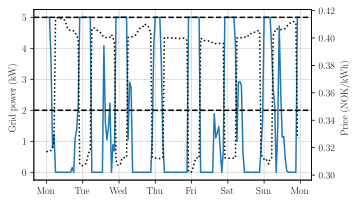

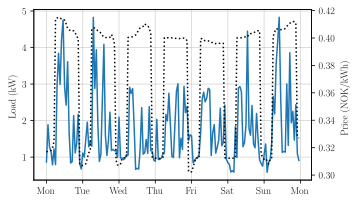

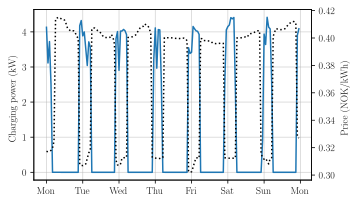

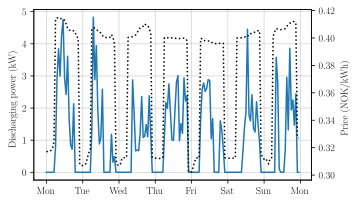

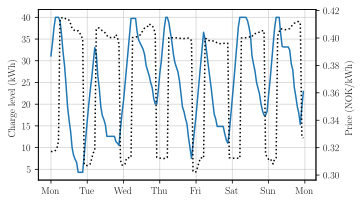

In [12]:
p_series = pd.Series(p_mpc, index=sim_datetime_index)
c_series = pd.Series(c_mpc, index=sim_datetime_index)
d_series = pd.Series(d_mpc, index=sim_datetime_index)
q_series = pd.Series(q_mpc[1:], index=sim_datetime_index)

# Grid power
fig, ax = plt.subplots()
ax.plot(p_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
ax.axhline(2, color='black', linestyle='dashed') 
ax.axhline(5, color='black', linestyle='dashed')
plt.ylabel("Grid power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/p_mpc_week.pdf")


# Load
fig, ax = plt.subplots()
ax.plot(l_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Load (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/l_mpc_week.pdf")

# Charging storage power
fig, ax = plt.subplots()
ax.plot(c_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Charging power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/c_mpc_week.pdf")

# Discharging storage power
fig, ax = plt.subplots()
ax.plot(d_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Discharging power (kW)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/d_mpc_week.pdf")

# Charge level
fig, ax = plt.subplots()
ax.plot(q_series['2022-07-04':'2022-07-10'].values, color="tab:blue")
plt.ylabel("Charge level (kWh)")
ax.set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2 = ax.twinx()
ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", linestyle="dotted", label="Price")
ax2.set_ylabel("Price (NOK/kWh)")
ax2.yaxis.tick_right()
ax2.grid(False)
plt.savefig("figures/q_mpc_week.pdf")

### Cost comparison

In [13]:
print(f"Cost without storage (baseline): {cost_no_storage:,.2f} NOK")
print(f"Cost with 40 kWh of storage capacity and prescient policy: {cost_prescient:,.2f} NOK")
print(f"Cost with 40 kWh of storage capacity and MPC policy: {cost_mpc:,.2f} NOK")

print(f"Annual savings with 40 kWh of storage capacity and prescient policy: {cost_no_storage-cost_prescient:.2f} NOK ({100 * (cost_no_storage-cost_prescient) / cost_no_storage:.2f}%)")
print(f"Annual savings with 40 kWh of storage capacity and MPC policy: {cost_no_storage-cost_mpc:.2f} NOK ({100 * (cost_no_storage-cost_mpc) / cost_no_storage:.2f}%)")
print(f"Gap between MPC cost and prescient performance bound: {(abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100:.2f}%")

Cost without storage (baseline): 25,051.67 NOK
Cost with 40 kWh of storage capacity and prescient policy: 21,203.53 NOK
Cost with 40 kWh of storage capacity and MPC policy: 21,563.47 NOK
Annual savings with 40 kWh of storage capacity and prescient policy: 3848.14 NOK (15.36%)
Annual savings with 40 kWh of storage capacity and MPC policy: 3488.20 NOK (13.92%)
Gap between MPC cost and prescient performance bound: 1.70%
